In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import re
import time

import sounddevice as sd
from scipy.io import wavfile

from multiprocess import Pool
import functools
import pdb

import sys
sys.path.insert(1, './functions')

from workflow import *
from read import *
from similarity import *
from helper import *
from display import *

In [2]:
# import session_info
# session_info.show()

In [3]:
sd.query_devices()
# sd.default.device = 3

> 0 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Air Speakers, Core Audio (0 in, 2 out)

In [4]:
samplerate, piano_audio = read_audio('Audio.wav')
if samplerate != 44100:
    print("Different sample rate - might cause issues in playing audio")
# sd.play(piano_audio, samplerate)

/Users/snehashah/Desktop/Stagecast/stagecast-dev/./functions/read.py:53: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, piano_audio = wavfile.read(filePath)


In [5]:
# sd.stop()

  Oops
  Oops


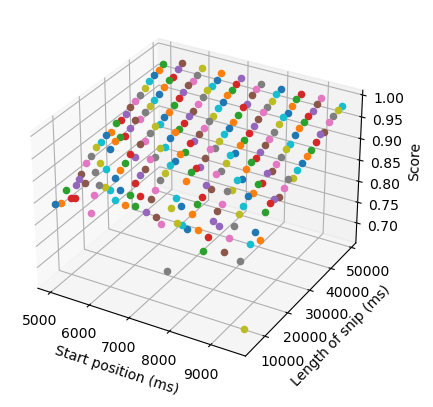

In [6]:
# Testing the above similarity score with different snippets of different playthroughs that "should" have a good score

midiPath = '../midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# matches=[]
for x in range(5000,10000,500):
#     print(x)
#     x = 0
    for y in range(5000,50000,2000):
        t1 = [y+x,0+x] # timestamps in ms
        t2 = [191400+y+x,191400+x]
#         t2 = [413000+y+x,413000+x]
#         t2 = [587000+y+x,587000+x]

        tf1 = time_to_sequence(notes, t1)
        tf2 = time_to_sequence(notes, t2)

        a,b,c,d,score = two_way_similarity(tf1,tf2,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,disp=False)
#         print(score)
#         matches.append([x,y,score])
        ax.scatter(x,y,score)
        if score<0.8:
            print("  Oops")
#             a,b,c,d,score = two_way_similarity(tf1,tf2,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,disp=True)
#             display_snippet_plot(notes, time_to_index(notes,t1[0]),time_to_index(notes,t1[1]),time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), score, t1[0], t2[0])
    #         play_match(piano_audio, t1[0],t1[1],t2[0],t2[1])
    #         predict(notes, time_to_index(notes,t1[0]), time_to_index(notes,t1[1]), time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), tf1[-1][0],pred_time=100,sound=True)
    #         time.sleep(2)
#         break
#     break

# plt.scatter3D(matches)
ax.set_xlabel('Start position (ms)')
ax.set_ylabel('Length of snip (ms)')
ax.set_zlabel('Score')
plt.show()

In [7]:
# Setting up parameters to run the matching algorithm

midiPath = '../midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

# hyperparameters
zero_penalty = 1
length_incentive = 500000 # 50 seconds yields 10% increase in score
max_offset = 600
timestamp_max_before_source = 5000 #ms behing the source timestamp
min_dist_const = 400 # acceptable time difference for same note
initial_alignment = "last note in source to match in target"
realignment = "mean offset of notes within max_offset dist - done once"
note_scoring = "penalize within min_dist"

# parameters
minNotes = 8
maxNotes = 200 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxTime = 30000 # if more matches, increase snippet length
thresh = 0.7
start = 191400
skip = 10
end = 365000

# Short time span for testing - comment out to run whole code
# start = 300400
# skip = 100
# end = 360000

fm = functools.partial(find_matches_at_timestamp, notes=notes, minNotes=minNotes, minTime=minTime, maxNotes=maxNotes, 
                       maxTime=maxTime, thresh=thresh, timestamp_max_before_source=timestamp_max_before_source, 
                       zero_penalty=zero_penalty, length_incentive=length_incentive, max_offset=max_offset, 
                       min_dist_const=min_dist_const, disp=False)

# Running with time allocation to functions - analyse speed and bottlenecks
# %prun sims_arr.extend(find_matches_at_timestamp(25000, notes, minNotes, minTime, maxNotes, maxTime, thresh, disp=False))



In [8]:
# Running match algorithm parallely

fm(25000)

sims_arr = []
curr_times = np.arange(start, end, skip)

with Pool(4) as p:
    sims_arr = p.map(fm, curr_times)

# storing matches as array of all matches
sarr = []
for i in range(len(sims_arr)):
    sarr.extend(sims_arr[i])

i:315000    191400    202250    213100    223950    202260    191410    213110    202270    223960    191420    202280    191430    213120    202290    223970    191440    202300    213130    191450    202310    223980    213140    191460    202320    191470    i:    202330    223990    191480    202340    213160    224000    202350    191490    213170    202360    191500    224010    202370    213180    191510    202380    202390    224020    191520    213190    202400    202410    191530    224030    213200    202420    202430    191540    213210    202440    224040    191550    202450    213220    202460    224050    191560    202470    213230    202480    191570    224060    202490    213240    191580    202500    224070    202510    213250    191590    202520    202530    191600    213260    224080    202540    191610    213270    202550    224090    202560    191620    213280    202570    224100    191630    202580    213290    191640    202590    224110    202600    213300    19

i:  214700    193650    205290    225250    214710    205300    193660    205310    193670    214720    225260    205320    193680    205330    214730    193690    225270    205340    193700    205350    214740    225280    193710    205360    205370    193720    214750    225290    205380    193730    205390    214760    193740    205400    225300    193750    214770    205410    193760    205420    225310    214780    193770    205430    205440    193780    225320    214790    205450    193790    205460    193800    225330    214800    205470    193810    205480    225340    193820    214810    205490    193830    205500    214820    225350    193840    205510    193850    214830    205520    225360    193860    205530    214840    193870    205540    225370    193880    205550    214850    193890    205560    225380    214860    193900    205570    205580    193910    225390    214870    205590    193920    225400    205600    214880    193930    205610    193940    214890    225410

i: 8006260    207870    216360    226590    196270    207880    196280    216370    207890    226600    196290    207900    216380    196300    207910    226610    196310    216390    207920    196320    207930    216400    226620    196330    207940    196340    216410    207950    226630    196350    207960    216420    196360    207970    226640    196370    216430    196380    207980    196390    226650    207990    216440    196400    208000    216450    196410    226660    208010    196420    208020    216460    226670    196430    208030    216470    196440    208040    226680    196450    216480    208050    196460    208060    226690    216490    196470    208070    196480    208080    216500    226700    196490    208090    196500    216510    226710    208100    196510    196520    208110    216520    196530    226720    208120    196540    216530    208130    196550    226730    208140    196560    216540    196570    208150    226740    216550    196580    208160    196590

i:  210240    199140    227970    210250    217940    199150    210260    199160    227980    217950    210270    199170    199180    210280    227990    199190    217960    210290    199200    228000    199210    210300    217970    199220    210310    199230    228010    217980    199240    210320    199250    228020    210330    217990    199260    199270    210340    228030    218000    199280    210350    199290    218010    228040    199300    210360    199310    210370    218020    199320    228050    210380    199330    218030    199340    210390    228060    199350    199360    210400    218040    199370    228070    210410    199380    218050    199390    210420    228080    199400    218060    199410    210430    199420    228090    210440    218070    199430    199440    210450    228100    199450    218080    199460    210460    199470    218090    228110    210470    199480    199490    210480    218100    199500    228120    199510    210490    218110    199520    210500

i:  234840    212430    229380    219380    234850    212440    229390    219390    212450    234860    212460    229400    219400    234870    212470    229410    234880    212480    219410    212490    229420    234890    219420    212500    229430    234900    212510    219430    229440    234910    212520    219440    212530    229450    234920    212540    219450    229460    234930    212550    229470    212560    219460    234940    212570    229480    219470    234950    212580    229490    212590    219480    234960    212600    229500    219490    212610    234970    229510    212620    219500    234980    212630    229520    212640    219510    229530    234990    212650    219520    212660    229540    235000    212670    219530    229550    212680    235010    212690    229560    219540    235020    212700    229570    219550    212710    235030    212720    229580    219560    212730    235040    229590    219570    212740    235050    229600    219580    212750    235060

i:  231450    247090    236850    221380    231460    247100    236860    221390    231470    236870    247110    221400    231480    236880    247120    221410    231490    236890    247130    221420    231500    236900    247140    221430    231510    236910    221440    247150    231520    236920    221450    247160    231530    236930    247170    221460    231540    236940    247180    221470    231550    236950    247190    221480    231560    236960    247200    231570    221490    236970    247210    231580    221500    236980    231590    247220    221510    236990    231600    247230    237000    221520    231610    237010    247240    221530    231620    237020    247250    221540    231630    237030    247260    221550    231640    237040    221560    247270    231650    237050    221570    231660    247280    237060    221580    231670    247290    237070    221590    231680    247300    237080    221600    231690    247310    237090    221610    231700    221620    237100

i:  238930    223460    248990    223470    233580    238940    249000    223480    233590    238950   i:i:  223490249010       233600    238960    223500    249020    233610    223510    238970    249030    233620    223520    238980    233630    249040    223530    238990    233640    223540    249050    239000    233650    223550    249060    239010    233660    223560    233670    239020    249070    223570    233680    239030    223580    249080    233690    239040    223590    249090    233700    239050    223600    233710   i:i:  249100   239060    223610    233720    239070    249110    223620    233730    239080    249120    223630    239090    233740    239100    223640    233750    249130    239110    223650    233760    249140    239120    223660    233770    249150    239130    223670    233780    239140    249160    223680    233790    239150    249170    223690    233800    239160    249180    223700    233810    239170    223710    249190    239180    233820    223720  

i: 350020    243280    253060    260070    243290    270030    253070    260080    243300    270040    253080    260090    243310    260100    243320    270050    253090    260110    243330    270060    253100    260120    243340    253110    270070    243350    260130    253120    270080    243360    260140    253130    243370    270090    260150    253140    243380    260160    270100    253150    243390    260170    270110    253160    243400    260180    253170    270120    243410    260190    253180    270130    243420    260200    253190    270140    243430    260210    253200    243440    270150    253210    260220    243450    253220    270160    260230    243460    253230    270170    260240    243470    253240    260250    270180    243480    253250    260260    270190    243490   i:253260    260270    270200    243500    253270    260280    270210    243510    253280    260290    243520    270220    253290    260300    243530    270230    253300    260310    243540    270240

i:  262100    271930    255140    245460    262110    271940    255150    245470    262120    255160    245480i: 271950    262130    245490    255170    271960    262140    245500    255180    271970    262150    245510    255190    271980    262160    255200    245520    271990    262170    255210    245530    262180    272000    255220    245540    262190    272010    255230    245550    262200    272020    255240    245560    262210    272030    255250    245570    262220    272040    255260    245580    255270    272050    262230    245590    255280    272060    262240    245600    255290    272070    245610    262250    255300    272080    245620    262260    255310    272090    245630    255320    262270    272100    245640    255330    262280    278200    272110    255340    262290    272120    278210    255350    272130    262300    278220    255360    272140    262310    255370    278230    272150    255380    262320    278240    272160    255390    262330    278250    272170 

i:  280080    273960    289840    264040    280090    273970    289850    264050    280100    273980    289860    264060    280110    273990    289870    264070    280120    274000    289880    264080    280130    274010    264090    289890    280140    274020    264100    280150    289900    274030    264110    280160    289910    274040    264120    280170    289920    274050    280180    264130    289930    274060    280190    264140    289940    274070    280200    264150    274080    289950    280210    264160    274090    280220    289960    264170    280230    274100    264180    289970    264190    280240    274110    289980    264200    274120    280250    289990    264210    274130    280260    290000    264220    274140    280270    290010    264230    274150    280280    264240    290020    274160    264250    280290    290030    274170    264260    290040    280300    264270    274180    290050    280310    264280    274190    290060    264290    280320    274200    290070

i: 276030    266170    291780    282130    276040    266180    291790    282140    266190    276050    291800    282150    266200    276060    291810    282160    266210    276070    291820    282170    266220    276080    291830    282180    266230    276090    291840    282190    266240    291850    276100    282200    266250    291860    276110    282210    266260    291870    276120    282220    266270    291880    276130    282230    266280    291890    282240i: 276140    266290    291900    282250    276150    266300    291910    282260    276160    266310    291920    282270    266320    276170    291930    282280    266330    276180    291940    282290    266340    276190    291950    282300    266350    276200    282310    291960    266360    276210    282320    291970    266370    276220    282330    266380    291980    276230    282340    266390    291990    276240    282350    266400    276250    292000    282360    266410    276260    292010    266420    282370    276270  

i:  278080    284160    300820    278090    293800    284170    300830    278100    284180    293810    300840    278110    284190    293820    300850    278120    284200    293830    300860    278130    284210    293840    300870    278140    284220    300880    293850    278150    300890    284230    278160    293860    300900    284240    278170    293870    300910    284250    278180    293880    300920    284260    278190    293890    300930    284270    310750    293900    300940    284280    310760    293910    300950    310770    284290    293920    300960    310780    284300    293930    300970    310790    284310    293940    300980    310800    284320    293950    300990    310810    284330    293960    301000    310820    284340    293970    310830    301010    284350    293980    310840    284360    293990    301020    310850    284370    294000    301030    284380    294010    310860    301040    284390    294020    310870    301050    284400    294030    310880    301060

i:  302860    312580    295880    286280    312590    302870    295890    312600    286290    302880    295900    312610    302890    286300    295910    312620    302900    286310    295920    312630    302910    286320    295930    312640    302920    295940    286330    312650    302930    295950    312660    302940    286340    295960    312670    302950    286350    295970    302960    312680    286360    295980    302970    312690    286370    295990    302980    312700    296000    302990    286380    312710    303000    296010    286390    312720    303010    296020    286400    303020    296030    312730    286410    296040    303030    312740    286420    296050    303040    312750    296060    286430    303050    296070    312760    303060    286440    296080    312770    303070    286450    296090    312780    296100    303080    286460    312790    296110    303090    286470    296120    312800    303100    286480    296130    312810    286490    303110    296140    286500

i:  297940    314540    288380    304930    297950    314550    288390    297960    304940    314560    288400    297970    304950    314570    297980    288410    304960    314580    297990    288420    304970    314590    298000    288430    304980    314600    298010    288440    304990    314610    298020    288450    305000    314620    298030    288460    305010    314630    298040    288470    305020    314640    288480    298050    305030    314650    288490    305040    298060    314660    305050    288500    298070    314670    305060    288510    298080    314680    305070    288520    298090    314690    305080    288530    298100    314700    305090    288540    298110    314710    305100    288550    314720    298120    305110    288560    314730    298130    305120    288570    314740    298140    305130    288580    298150i: 314750    288590    305140    298160    314760    288600    305150    298170    288610    314770    305160    298180    288620    314780    305170 

i: 322860    316600    307020    322870    316610    332600    307030    316620    322880    332610    307040    316630    322890    332620    307050    316640    322900    307060    316650    332630    322910    316660    307070    332640    322920    316670    307080    332650    316680    322930    307090    332660    316690    307100    322940    316700    332670    307110    322950    316710    332680    307120    316720    322960    332690    307130    316730    322970    332700    307140    316740    332710    322980    316750    307150    316760    332720    322990    307160    316770    332730    307170    323000    316780    307180    332740    316790    323010    307190    316800    323020    332750    316810    307200    323030    332760    316820    307210    323040    316830    307220    332770    316840    323050    307230    316850    332780    323060    307240    316860    323070    332790    307250    316870    323080    307260    316880    332800    323090    316890 

i:  324810    309220    318960    334280    309230    324820    318970    309240    334290    318980    324830    309250    318990    324840    309260    334300    319000    309270    324850    334310    309280    319010    324860    309290    319020    334320    324870    309300    319030    324880    309310    334330    319040    309320    324890    319050    309330    334340    324900    319060    309340    324910    334350    309350    319070    324920    309360    319080    334360    324930    309370    319090    334370    309380    324940    319100    309390    319110    324950    334380    309400    319120    324960    334390    309410    319130    324970    319140    309420    334400    319150    324980    309430    334410    319160    309440    324990    319170    334420    309450    325000    319180    309460    334430    319190    325010    309470    319200    334440    309480    325020    319210    309490    334450    319220    325030    309500    334460    319230    309510

i: 326760    343880    321400    335970    326770    321410    343890    335980    326780    321420    343900    335990    321430    326790    321440    336000    343910    326800    321450    336010    326810    343920    321460    336020    326820    321470    343930    321480    336030    326830    321490    343940    336040    326840    321500    343950    321510    336050    326850    321520    326860    336060    343960    321530    326870    321540    336070    343970    321550    326880    336080    321560    343980    326890    321570    336090    321580    343990    326900    321590    336100    326910    344000    354150    336110    326920    344010    354160    336120    326930    354170    344020    326940    336130    354180    344030    326950    336140    354190    326960    344040    336150    354200    326970    344050    336160    354210    326980    344060    326990    354220    336170    344070    327000    354230    336180    327010    344080    354240    336190 

i:  356140    337930    328980    356150    345700    337940    328990    356160    345710    329000    337950    356170    345720    329010    356180    337960    329020    345730    356190    337970    329030    356200    345740    337980    329040    356210    345750    337990    329050    356220    338000    329060    345760    356230    329070    338010    345770    329080    356240    338020    329090    345780    356250    329100    338030    356260    329110    345790    338040    329120    356270    345800    338050    329130    356280    329140    338060    345810    356290    329150    338070    345820    356300    329160    338080    345830    329170    356310    338090    329180    345840    356320    338100    329190    356330    345850    338110    329200    356340    345860    338120    329210    356350    338130    345870    329220    356360    329230    338140    345880    356370    329240    338150    345890    356380    329250    356390    338160    345900    329260

i: 360620    342010    350050    360630    342020    350060    360640    350070    342030    360650    350080    342040    350090    360660    342050    350100    360670    342060    350110    360680    350120    342070    360690    350130    342080    360700    350140    342090    360710    350150    360720    342100    350160    360730    350170    342110    360740    350180    342120    360750    350190    342130    360760    350200    342140    360770    350210    342150    360780    350220    342160    360790    350230    360800    342170    350240    360810    350250    342180    360820    350260    342190    360830    350270    342200    360840    350280    342210    360850    350290    360860    342220    350300    360870    342230    350310    360880    350320    342240    360890    350330    342250    360900    350340    342260    350350    360910    342270    350360    360920    342280    350370    360930    350380    342290    360940    350390    342300    360950    350400 

i: 363890    353680    363900    353690    363910    353700    363920    353710    353720    363930    353730    363940    353740    363950    353750    363960    353760    363970    353770    363980    353780    363990    353790    364000    353800    353810    364010    353820    364020    353830    364030    353840    364040    353850    364050    353860    364060    353870    353880    364070    353890    364080    353900    364090    353910    364100    353920    364110    353930    353940    364120    353950    364130    353960    364140    353970    364150    353980    364160    353990    354000    364170    354010    364180    354020    364190    354030    364200    354040    364210    354050    364220    354060    364230    354070    364240    354080    364250    354090    354100    364260    354110    364270    354120    364280    354130    364290    354140    364300    364310    364320    364330    364340    364350    364360    364370    364380    364390    364400    364410 

In [9]:
# simsDF_1 = simsDF_old
# simsDFall_1 = simsDFall_old
# simsDF_2 = simsDF_old
# simsDFall_2 = simsDFall_old
# simsDF_old = simsDF
# simsDFall_old = simsDFall


In [10]:
## choosing only significant scores and storing the new data in sims_plot

sarr = np.array(sarr)
sims_thresh = sarr * (sarr>thresh) # considering a match if score greater than a threshold

simsDF = pd.DataFrame(data=sims_thresh.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
simsDFall = pd.DataFrame(data=sarr.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])


<AxesSubplot:title={'center':'All matches >0.7, for \nMin Notes=8 notes, Max Notes=200'}, xlabel='source_timestamp', ylabel='target_timestamp'>

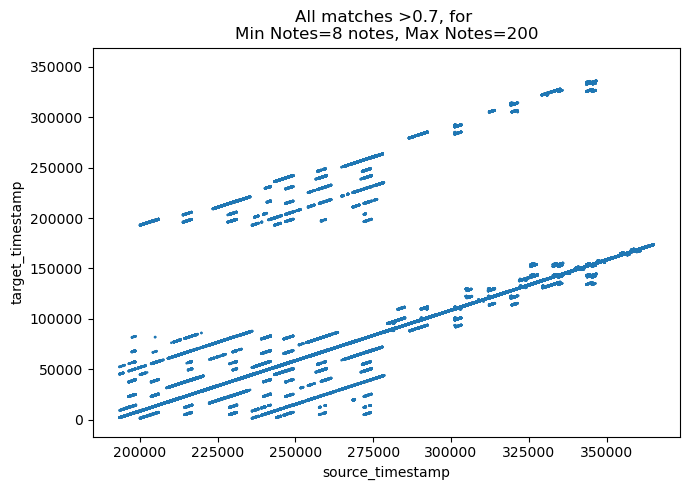

In [11]:
# plotting all mathes > threshold score

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Notes=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)


Percentage matches found: 98.8%
Percentage matches >0.7 found: 98.6%
Percentage matches within 50ms of line: 86.9%
Percentage matches >0.7 and within 50ms of the line: 86.9%
Minimum score of a "right match": 0.70


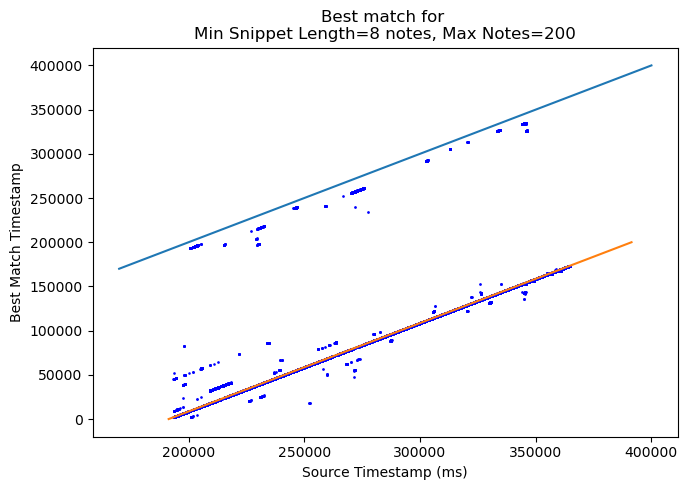

In [12]:
# Plotting best match only

percentage_matches_any = 0
percentage_matches_thresh = 0
percentage_matches_line = 0
percentage_matches_thresh_line = 0
acc = 50                            #ms accuracy for distance from line

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True
bestMatches = []

toPlot = simsDFall
# toPlot = simsDFall_old

total = 0
distribution_hist = []
distribution_all = []
close_matches = []
min_good_score = 1
for x in range(start,end,skip):
    y = toPlot.loc[toPlot['source_timestamp'] == x]['score']
    total += 1
    if y.any(): 
        y = y.idxmax()
        percentage_matches_any += 1
        if toPlot['score'].loc[y] > thresh:
            percentage_matches_thresh += 1
            if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
                percentage_matches_thresh_line += 1
        if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
            if toPlot['score'].loc[y] < min_good_score:
                min_good_score = toPlot['score'].loc[y]
            distribution_hist.append((toPlot['target_timestamp'].loc[y]-(x-191400)))
            distribution_all.append([x,(toPlot['target_timestamp'].loc[y]-(x-191400))])
            percentage_matches_line += 1
            close_matches.append(toPlot.loc[y].tolist())
    else:
        continue
#     bestMatch = [toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],toPlot['source_id_start'].loc[y],toPlot['source_id_end'].loc[y],toPlot['target_id_start'].loc[y],toPlot['target_id_end'].loc[y]]
#     bestMatches.append(bestMatch)
    plt.scatter(toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],c='blue')
# bestMatches = np.array(bestMatches)
# bestMatchesDF = pd.DataFrame(data=bestMatches, columns=["source_timestamp","target_timestamp", "score", "source_id_start", "source_id_end", "target_id_start", "target_id_end"])   

plt.plot(np.arange(170000,400000),np.arange(170000,400000))
plt.plot(np.arange(191400,391400),np.arange(200000))
percentage_matches_any /= total
percentage_matches_thresh /= total
percentage_matches_line /= total
percentage_matches_thresh_line /= total
print("Percentage matches found: {:.1f}%".format(percentage_matches_any*100))
print("Percentage matches >{:.1f} found: {:.1f}%".format(thresh,percentage_matches_thresh*100))
print("Percentage matches within {:d}ms of line: {:.1f}%".format(acc,percentage_matches_line*100))
print("Percentage matches >{:.1f} and within {:d}ms of the line: {:.1f}%".format(thresh,acc,percentage_matches_thresh_line*100))
print("Minimum score of a \"right match\": {:.2f}".format(min_good_score))

plt.title("Best match for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Timestamp")
plt.show()


Distribution Mean:-1.30
Distribution Standad Deviation:11.86


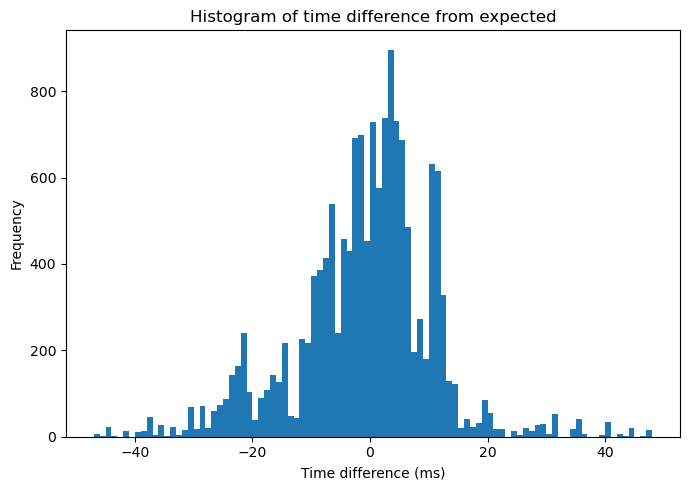

In [13]:
# also plot histogram
mean = np.mean(distribution_hist)
std = np.std(distribution_hist)
print("Distribution Mean:{:.2f}".format(mean))
print("Distribution Standad Deviation:{:.2f}".format(std))
plt.hist(distribution_hist,bins=int(max(distribution_hist)-min(distribution_hist)))
plt.title("Histogram of time difference from expected")
plt.xlabel("Time difference (ms)")
plt.ylabel("Frequency")
plt.show()

Distribution Mean:5.05
Distribution Standad Deviation:29.32


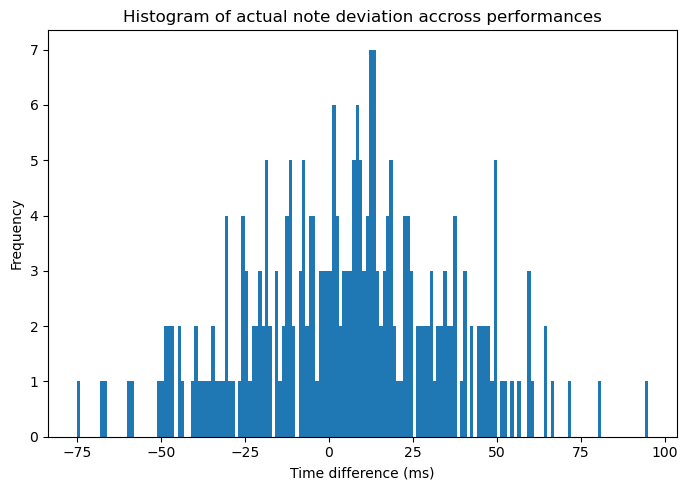

In [14]:
# Note distribution in first vs second playthrough

note_distribution_hist = []
for note in notes[time_to_index(notes,start):time_to_index(notes,end)]:
    # find closest note in history
    note2 = find_note(notes, note[0]-191400, note[1], max_time_dist = 100)
    if note2:
        note_distribution_hist.append(note[0]-notes[note2][0]-191400)
    
mean = np.mean(note_distribution_hist)
std = np.std(note_distribution_hist)
print("Distribution Mean:{:.2f}".format(mean))
print("Distribution Standad Deviation:{:.2f}".format(std))
plt.hist(note_distribution_hist,bins=int(max(note_distribution_hist)-min(note_distribution_hist)))
plt.title("Histogram of actual note deviation accross performances")
plt.xlabel("Time difference (ms)")
plt.ylabel("Frequency")
plt.show()

(15093, 9)
source_timestamp    193470.000000
target_timestamp      2067.000000
score                    0.715674
source_id_start        766.000000
source_id_end          758.000000
target_id_start          6.000000
target_id_end            2.000000
match_len                8.000000
match_time            1796.000000
deviation               -3.000000
Name: 0, dtype: float64
(1, 10)
[[279810  88458      0   1090   1082    340    330      8   2326     48]]
[279810  88458      0   1090   1082    340    330      8   2326     48]


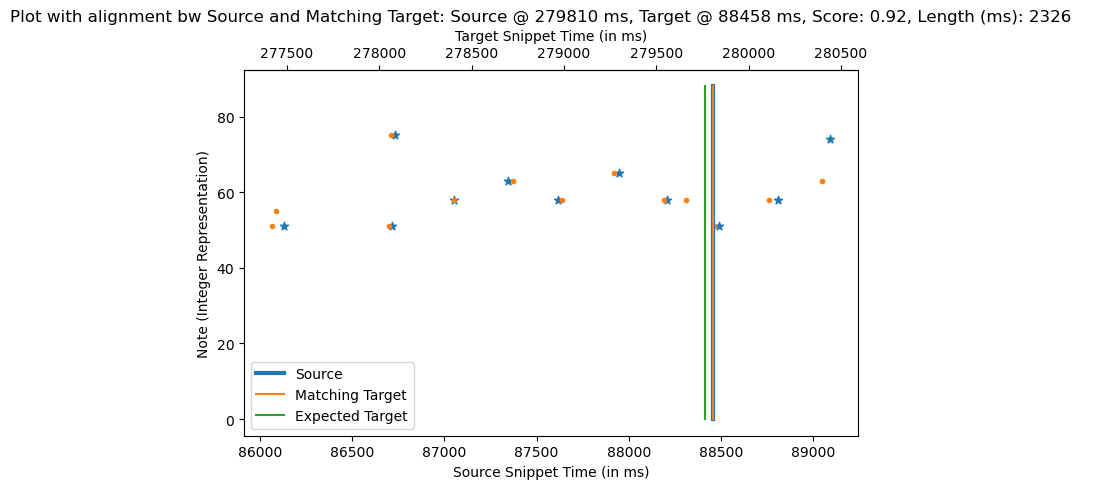

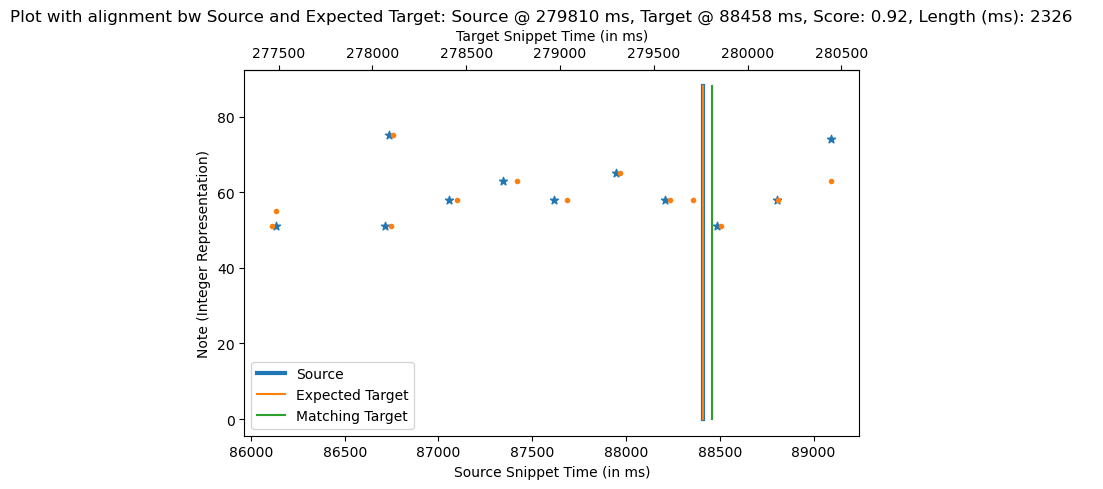

Plot with Source and Matching Target aligned: Source @ 279810 ms, Target @ 88458 ms, Score: 0.92, Length (ms): 2326    
Source end notes:
 [[279296     65     55]
 [279559     58     57]
 [279838     51     54]
 [280158     58     56]
 [280444     74     67]]
Source end notes - 191400: [87896 88159 88438 88758 89044]
Target end notes:
 [[88189    58    57]
 [88307    58    15]
 [88460    51    58]
 [88760    58    49]
 [89046    63    56]]
Source diff between notes: [263 279 320 286]
Target diff between notes: [118 153 300 286]
Source time - last note: 251.0
Target time - last note: 151.0



In [15]:
#['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time']
k = 1

# dtype = [('source_timestamp', float), ('target_timestamp', float), ('score', float),('source_id_start', float),\
#          ('source_id_end', float),('target_id_start', float),('target_id_end', float),('match_len', float),('match_time', float)]

close_matches_array = np.array(close_matches)
distribution_hist_array = np.array(distribution_hist)
print(close_matches_array.shape)
close_matches_df = pd.DataFrame(data = close_matches_array, columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
close_matches_df['deviation'] = distribution_hist_array

close_matches_sorted = close_matches_df.sort_values(by=['deviation'])

worst_matches = np.array(close_matches_sorted.iloc[-k:],dtype=float)

print(close_matches_df.iloc[0])
print(worst_matches.shape)
print(worst_matches.astype(int))
for match in worst_matches:
    print(match.astype(int))
    source_start = int(match[0])
    target_start = int(match[1])
    score = match[2]
    source_id_start = int(match[3])
    source_id_end = int(match[4])
    target_id_start = int(match[5])
    target_id_end = int(match[6])
    match_len = int(match[7])
    match_time = int(match[8])
    
    # plot worst match (in terms of distance from expected timestamp)
    diff = source_start - target_start
    sequence1 = np.copy(notes[source_id_end:source_id_start+3])
    sequence1[:,0] = sequence1[:,0]-diff
    sequence2 = np.copy(notes[target_id_end:target_id_start+3])
    sequence2[:,0] = sequence2[:,0]
    sequence3 = sequence2.copy()
    sequence3[:,0] = sequence2[:,0]-diff+191400
    
    display_expected_actual(sequence1,sequence2,source_start,target_start,source_start-diff,target_start,source_start-191400,diff,score,match_time,l1="Source",l2="Matching Target",l3="Expected Target")
    display_expected_actual(sequence1,sequence3,source_start,target_start,source_start-191400,source_start-191400,target_start,diff,score,match_time,l1="Source",l2="Expected Target",l3="Matching Target")
    
    l1="Source"
    l2="Matching Target"
    title = "Plot with {:s} and {:s} aligned: Source @ {:d} ms, Target @ {:d} ms, Score: {:.2f}, Length (ms): {:d}\
    ".format(l1,l2,source_start,target_start,score,match_time)
    print(title)
    
    a = notes[source_id_start-2:source_id_start+3]
    b = notes[target_id_start-2:target_id_start+3]
    print("Source end notes:\n",a)
    print("Source end notes - 191400:",a[:,0] - 191400)
    print("Target end notes:\n",b)
    print("Source diff between notes:",a[1:,0] - a[:-1,0])
    print("Target diff between notes:",b[1:,0] - b[:-1,0])
    print("Source time - last note:",match[0]-notes[int(match[3])-1][0])
    print("Target time - last note:",match[1]-notes[int(match[5])-1][0])
    print()

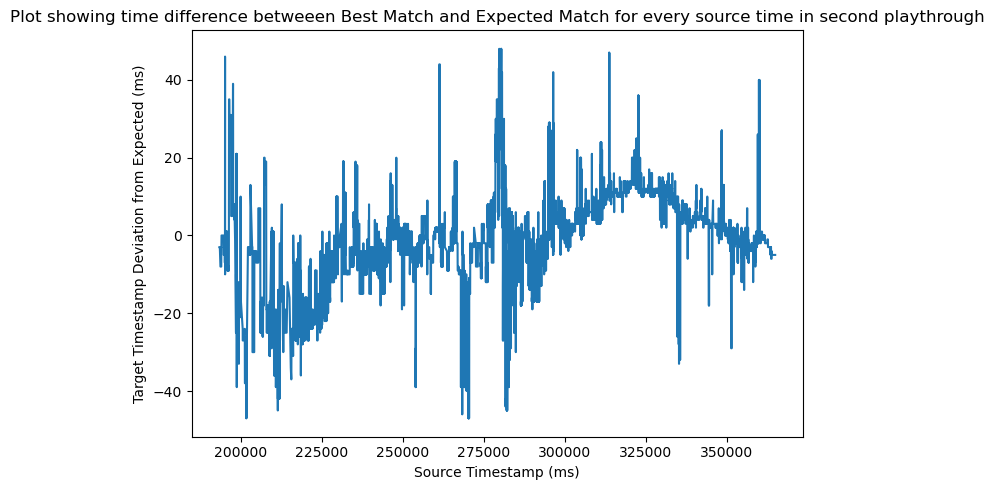

In [16]:
# Plotting diff vs source time

distribution_all_arr = np.array(distribution_all)
plt.plot(distribution_all_arr[:,0],distribution_all_arr[:,1])
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Target Timestamp Deviation from Expected (ms)")
plt.title("Plot showing time difference betweeen Best Match and Expected Match for every source time in second playthrough")
plt.show()

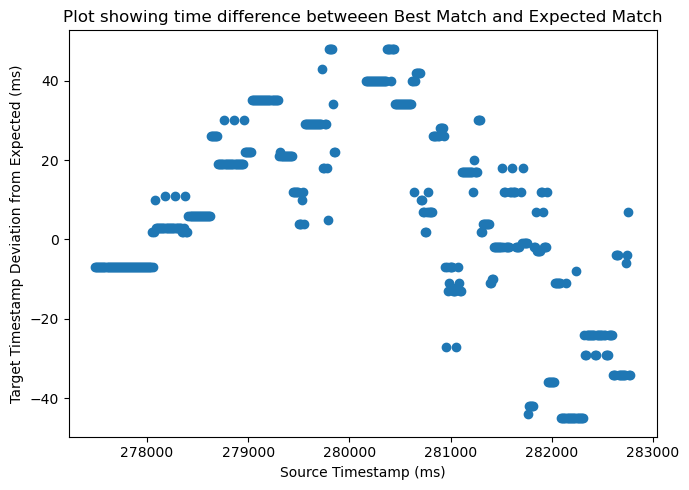

In [17]:
# Plotting diff vs source time - within a range

source_time = 275000 # timestamp to zoom into
index = (source_time - start)//skip
index -= 1500
len_match = 500

# Getting match details near source time we're interested in
# Can use this to make display_snippet plots
# matches_near_source = np.array(close_matches_df.iloc[index:index+500])

distribution_all_arr = np.array(distribution_all)
plt.scatter(distribution_all_arr[index:index+len_match,0],distribution_all_arr[index:index+len_match,1])
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Target Timestamp Deviation from Expected (ms)")
plt.title("Plot showing time difference betweeen Best Match and Expected Match")
plt.show()

In [18]:
pop_a = mpatches.Patch(color='blue', label='Unexpected match')
pop_b = mpatches.Patch(color='orange', label='On the line match')

210


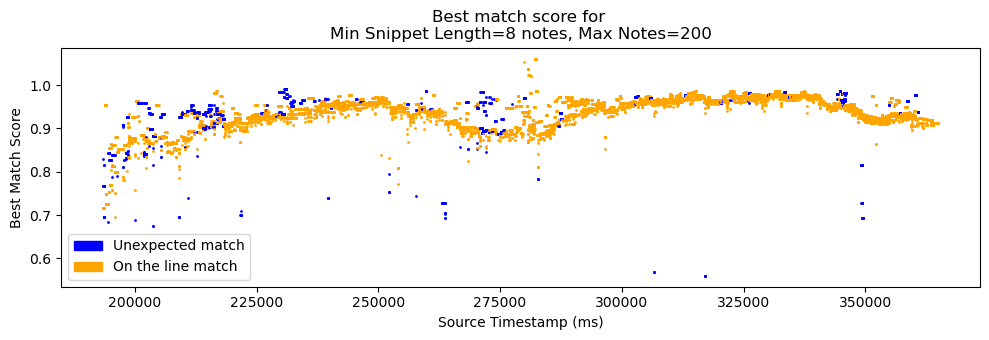

In [19]:
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in curr_times:
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    else:
        if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_len'] == s)]['target_timestamp']-(x-191400))<100).any():
            color = 'orange'
        else:
            color = 'blue'
        plt.scatter(x,y,1,c=color) # need to include s (len of best match)

# currDF = simsDFall.copy()
# currDF.sort_values(['source_timestamp', 'score', 'match_len'], ascending=[True, False, False]).drop_duplicates(['source_timestamp']).reset_index(drop=True)
# plt.scatter(curr_times,currDF.loc[currDF['source_timestamp'] == curr_times]['score'],currDF.loc[currDF['source_timestamp'] == curr_times]['match_len'])
# scores = s.max(axis = 0)
# # if np.isnan(y):
# #     count += 1
# #     y = 0
    

print(count)
plt.title("Best match score for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Score")
plt.legend(handles=[pop_a,pop_b])
plt.show()

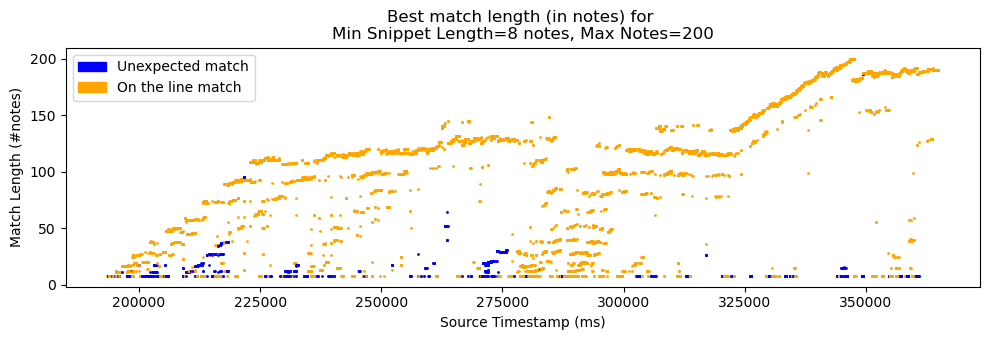

In [20]:
# Plotting note length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    
    if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_len'] == s)]['target_timestamp']-(x-191400))<100).any():
        color = 'orange'
    else:
        color = 'blue'
    plt.scatter(x,s,1,c=color)
    
# print(count)
plt.title("Best match length (in notes) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (#notes)")
plt.legend(handles=[pop_a,pop_b])
plt.show()

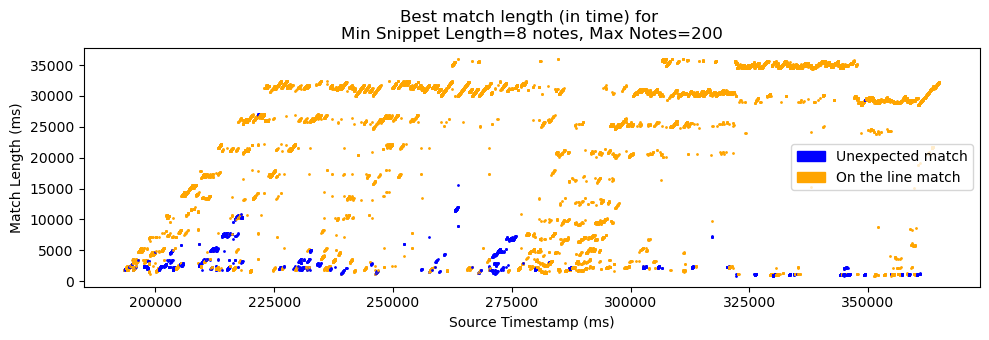

In [21]:
# Plotting time length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_time'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_time'] == s)]['target_timestamp']-(x-191400))<100).any():
        color = 'orange'
    else:
        color = 'blue'
    plt.scatter(x,s,1,c=color)
    
# print(count)
plt.title("Best match length (in time) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (ms)")
plt.legend(handles=[pop_a,pop_b])
plt.show()